In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
import pydotplus 
from IPython.display import Image 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
def discretize_data(dataset, variables):
    for variable in variables:
        var = sorted(dataset[variable].unique())
        mapping = dict(zip(var, range(0, len(var) + 1)))
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=classes))

For this analysis the dataset *customer_dataframe_big.csv* will be used, since it contains all the features for the customers.
Then, joining with the dataset created from Fuzzy K-Means we add the labeling to the various customers.   

In [3]:
df = pd.read_csv('datasets/clustered_fuzzy_dataframe.csv', sep='\t', index_col=0)
df_customer = pd.read_csv('datasets/customer_dataframe_big.csv', sep='\t', index_col=0)

df_customer.set_index("CustomerID", inplace = True)
df_customer['Label'] = df['Label']
df_customer.info()

# Size of different classes in the dataset
print("-------------------------")
for i in ['Low_Spend', 'Med_Spend', 'High_Spend']:
    print(i, len(df_customer[df_customer['Label'] == i]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MaxPO           4333 non-null   int64  
 3   MinPO           4333 non-null   int64  
 4   MeanProdOrder   4333 non-null   float64
 5   TSale           4333 non-null   float64
 6   TSaleWRet       4333 non-null   float64
 7   MinPSale        4333 non-null   float64
 8   MaxPSale        4333 non-null   float64
 9   MeanSaleOrder   4333 non-null   float64
 10  TRProd          4333 non-null   int64  
 11  MeanPSale       4333 non-null   float64
 12  TOrder          4333 non-null   int64  
 13  OrderMonth      4333 non-null   float64
 14  ProdMonth       4333 non-null   float64
 15  SaleMonth       4333 non-null   float64
 16  SETSaleQta      4333 non-null   float64
 17  SESaleQtaOrder  4333 non-nul

The target of this analysis is to use all the features that are not exploited by the clustering to assign the customers to a class.

In [4]:
# Drop all the features that are not time dependent and not usefull to generalize the behaviour of a customer
df_customer = discretize_data(df_customer,['MaxOrderMonth','Label'])
df_aux = df_customer.drop(columns=['TProd', 'MaxPO', 'MinPO', 'MeanProdOrder', 'TSaleWRet', 'MinPSale', 'MaxPSale', 'MeanSaleOrder',
                                   'MeanPSale', 'MaxOrderMonth', 'MaxOrderMonth', 'MaxOrderDay', 'Label', 'TRProd', 
                                   'SETSaleQta', 'SESaleQtaOrder', 'SEShoppingDays', 'DProd', 'TSale', 'TOrder'], errors='ignore')
df_class = df_aux.copy()
df_class.tail()

,OrderMonth,ProdMonth,SaleMonth,MonthPresence,MeanTimeGap,MaxOrderMonth_num,Label_num
CustomerID,,,,,,,
13436,0.083,6.333,16.407,0.083,0.0,2,1
15520,0.083,26.167,28.625,0.083,0.0,2,2
13298,0.083,8.000,30.000,0.083,0.0,2,1
14569,0.083,6.583,18.949,0.083,0.0,2,1
12713,0.083,42.083,66.212,0.083,0.0,2,2


# Decision Tree

In [5]:
label = df_class.pop('Label_num')
train_set, test_set, train_label, test_label = train_test_split(df_class, label, stratify =label, test_size=0.35)
print(f"Class HighSpend\nTrain: {len(train_label[train_label == 0])}\nTest: {len(test_label[test_label == 0])}")

Class HighSpend
Train: 105
Test: 56


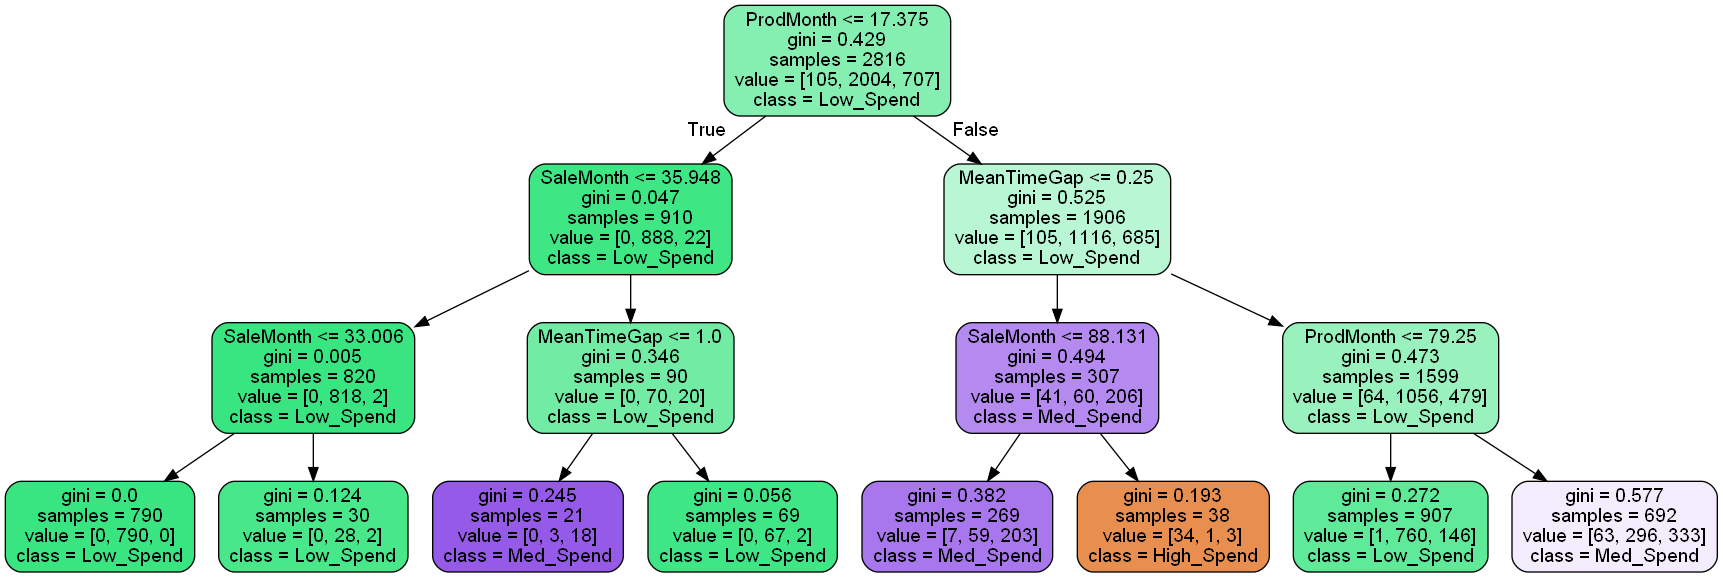

In [6]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, min_samples_split=17, min_samples_leaf=20)
dt = dt.fit(train_set, train_label)
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=list(train_set.columns), class_names=classes, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [7]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.94      0.29      0.44        56
   Low_Spend       0.91      0.82      0.86      1080
   Med_Spend       0.55      0.76      0.64       381

    accuracy                           0.78      1517
   macro avg       0.80      0.62      0.64      1517
weighted avg       0.82      0.78      0.79      1517



***